# Optimized DMD for denoising flow data

In [1]:
import sys
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
from os import makedirs, environ
from os.path import join
from copy import deepcopy
from collections import defaultdict
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, environ.get("FLOWTORCH_INSTALL_DIR"))
from flowtorch.data import FOAMDataloader
from flowtorch.analysis import SVD, LinearModel, DMD
from pydmd import BOPDMD
from IPython.display import clear_output

plt.rcParams["figure.dpi"] = 160
plt.rcParams["text.usetex"] = True
source = environ.get("FLOW_DATA_DIR")
output = join("output", "cylinder_2D_Re100")
makedirs(output, exist_ok=True)

def set_seed(seed):
    pt.manual_seed(seed)
    np.random.seed(seed)

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


In [2]:
L_REF = 0.1 # cylinder diameter in m
U_REF = 1.0  # maximum inlet velocity in m/s
NU = 1.0e-3  # kinematic viscosity in m^2/s
print(f"Re ={L_REF * U_REF / NU: 1.1f}")

Re = 100.0


In [3]:
def assemble_data_matrix(path, t_start, n_cycles, every, f_vortex=1.89962008):
    loader = FOAMDataloader(path, distributed=True, dtype=pt.float32)
    times = loader.write_times
    times = [t for t in times if float(t) >= t_start][::every]
    dt = float(times[1]) - float(times[0])
    n_steps = int(n_cycles / f_vortex / dt)
    times = times[:min(n_steps, len(times))]
    vertices = loader.vertices
    weights = loader.weights
    x, y, _ = vertices[:, 0], vertices[:, 1], vertices[:, 2]
    dm = loader.load_snapshot("vorticity", times)[:, 2, :]
    times = pt.tensor([float(t) for t in times])
    return x, y, times - times[0], weights, dm

In [4]:
case = join(source, "cylinder2D", "cylinder_2D_Re100_m1")
x, y, times, w, dm = assemble_data_matrix(case, 10, 2, 1)

Loading precomputed cell centers and volumes from processor0/constant
Loading precomputed cell centers and volumes from processor1/constant


In [5]:
dm.shape

torch.Size([39200, 526])

In [6]:
mean = dm.mean(dim=1)
dm_mean_subtracted = dm - mean.unsqueeze(-1)
svd = SVD(dm_mean_subtracted, rank=dm.shape[1])
print(svd)

SVD of a 39200x526 data matrix
Selected/optimal rank: 526/180
data type: torch.float32 (4b)
truncated SVD size: 79.7134Mb


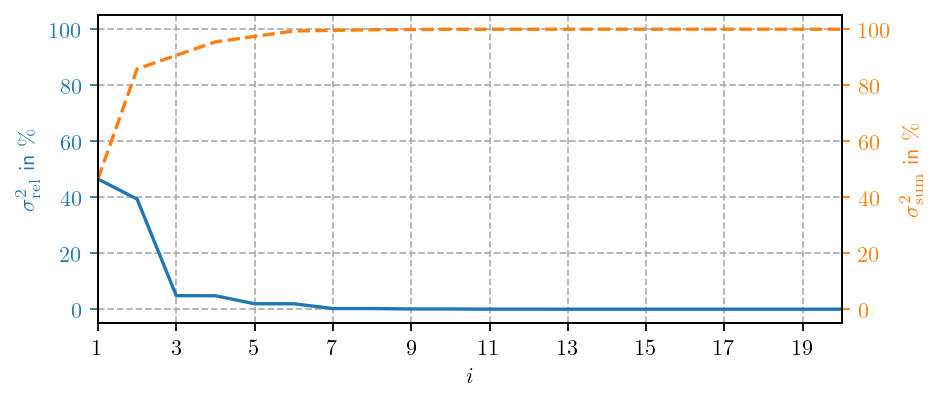

In [7]:
fig, ax = plt.subplots(figsize=(6, 2.5))
ax_sum = ax.twinx()
lam = svd.s**2 / (dm.shape[1] - 1)
lam_rel = lam / lam.sum() * 100
lam_sum = [lam_rel[:i].sum() for i in range(1, len(lam_rel))]
ind = list(range(1, dm.shape[1]+1))
n_show = 20
ax.plot(ind[:n_show], lam_rel[:n_show], c="C0")
ax_sum.plot(ind[:n_show], lam_sum[:n_show], c="C1", ls="--")

ax.grid(ls="--")
ax.set_ylim(-5, 105)
ax.set_xlim(1, n_show)
ax.set_xlabel(r"$i$")
ax.set_xticks(range(1, n_show+1, 2))
ax.set_ylabel(r"$\sigma^2_\mathrm{rel}$ in $\%$")
ax.yaxis.label.set_color("C0")
ax.tick_params(axis="y", colors="C0")
ax_sum.set_ylim(-5, 105)
ax_sum.set_ylabel(r"$\sigma^2_\mathrm{sum}$ in $\%$")
ax_sum.yaxis.label.set_color("C1")
ax_sum.tick_params(axis="y", colors="C1")
plt.show()

In [8]:
def add_contour(ax, field, vmin, vmax, cmap="PRGn"):
    levels = pt.linspace(vmin, vmax, 240)
    cont = ax.tricontourf(x, y, field, levels=levels, vmin=vmin, vmax=vmax, cmap=cmap, extend="both")
    ax.add_patch(plt.Circle((0.2, 0.2), 0.05, color='k'))
    ax.set_aspect("equal", 'box')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(0, 1.5)
    return cont

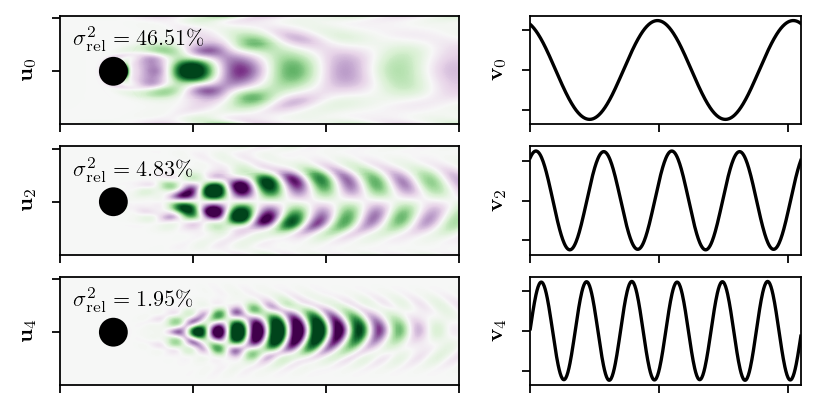

In [9]:
n_show = 3
fix, axarr = plt.subplots(n_show, 2, figsize=(6, n_show*1.0), gridspec_kw={"width_ratios": [3, 2]})
for i, ii in enumerate(range(0, 2*n_show, 2)):
    add_contour(axarr[i, 0], svd.U[:, ii], -0.025, 0.025)
    axarr[i, 0].set_ylabel(rf"$\mathbf{{u}}_{ii:1d}$")
    axarr[i, 1].plot(times*U_REF/L_REF, svd.V[:, ii], c="k")
    axarr[i, 1].set_xlim(0, times[-1]*U_REF/L_REF)
    axarr[i, 1].set_xticks([0.0, 5.0, 10.0])
    axarr[i, 1].set_yticklabels([])
    axarr[i, 1].set_ylabel(rf"$\mathbf{{v}}_{ii:1d}$")
    axarr[i, 0].set_xticklabels([])
    axarr[i, 1].set_xticklabels([])
    axarr[i, 0].text(0.05, 0.3, rf"$\sigma^2_\mathrm{{rel}}={lam_rel[ii]:1.2f}\%$")

plt.savefig(join(output, "top_modes_coeffs.png"), dpi=640, bbox_inches="tight")

In [10]:
def apply_noise(dm: pt.Tensor, noise_level: float = 0.0):
    _, N = dm.shape
    std = dm.std(dim=1).unsqueeze(-1).repeat(1, N) * noise_level * 0.01
    return dm + pt.normal(pt.zeros_like(dm), std)

In [11]:
rank = 6
dm_red = svd.U[:, :rank].T @ dm_mean_subtracted
dm_norm = ((dm_red - dm_red.min()) / (dm_red.max() - dm_red.min()) - 0.5) * 2
dm_norm.shape

torch.Size([6, 526])

In [12]:
noise_levels = (10, 20, 40)

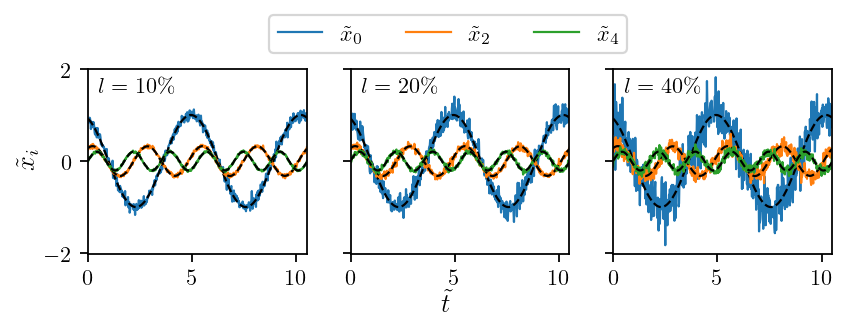

In [13]:
set_seed(0)
fig, axarr = plt.subplots(1, len(noise_levels), figsize=(6, 1.5), sharex=True, sharey=True)

for j, l in enumerate(noise_levels):
    dm_noisy = apply_noise(dm_norm, l)
    axarr[j].text(0.5, 1.5, rf"$l={l}\%$")
    for i in range(0, rank, 2):
        axarr[j].plot(times*U_REF/L_REF, dm_noisy[i], lw=1, label=rf"$\tilde{{x}}_{i:1d}$")
        axarr[j].plot(times*U_REF/L_REF, dm_norm[i], lw=1, ls="--", c="k")
        axarr[j].set_xlim(0, times[-1]*U_REF/L_REF)
handles, labels = axarr[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.15))
fig.supxlabel(r"$\tilde{t}$", y=-0.15)
fig.supylabel(r"$\tilde{x}_i$", x=0.05)
plt.savefig(join(output, "noisy_coeffs.png"), dpi=640, bbox_inches="tight")

In [14]:
device = "cuda" if pt.cuda.is_available() else "cpu"
dt = times[1] - times[0]

In [15]:
def test_horizon(dm_true, horizons, noise_levels, n_repeat):
    results = defaultdict(list)
    true_norm = dm_true.norm()
    n_test_noise = int(0.5 * dm_true.shape[1])
    n_tests = len(horizons) * len(noise_levels) * n_repeat
    count = 1
    for l in noise_levels:
        for i in range(n_repeat):
            set_seed(i)
            dm_noisy = apply_noise(dm_true, l)
            noise = dm_noisy - dm_true
            noise_norm = noise[:, :n_test_noise].norm()
            for h in horizons:
                print(f"Running test {count}/{n_tests}")
                lm = LinearModel(dm_noisy, dt, decompose_operator=True, rank=rank)
                lm.train(
                    2000,
                    split_options={
                    "horizon" : h,
                    "n_shift" : 1,
                    "train_size" : 0.9,
                    "test_size" : 0.1,
                    "forward_backward" : True
                    },
                stopping_options={"checkpoint" : "/tmp/best_model.pt"},
                optimizer_options={"lr" : 2.5e-3},
                device=device
                )
                lm.load_state_dict(pt.load("/tmp/best_model.pt", weights_only=True))
                pred = lm.predict(dm_true[:, 0], dm_true.shape[1]-1)
                base_key = f"l{l}_h{h}"
                results[base_key + "_pred_err"].append((pred - dm_true).norm() / true_norm)
                results[base_key + "_noise_err"].append((lm.noise[0][:, :n_test_noise] - noise[:, :n_test_noise]).norm() / noise_norm)
                clear_output()
                count += 1
    return results

In [16]:
horizons = (4, 8, 16, 32, 64, 128)

In [ ]:
results_horizon = test_horizon(dm_norm, horizons, noise_levels, 20)
pt.save(results_horizon, join(output, "test_horizon.pt"))

In [17]:
results_horizon = pt.load(join(output, "test_horizon.pt"), weights_only=False)

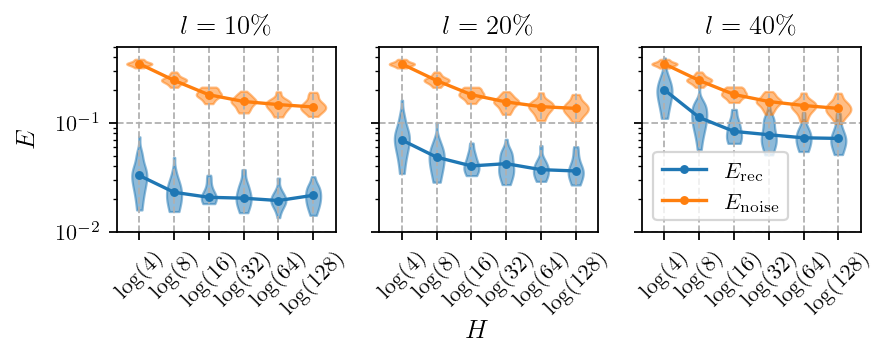

In [18]:
fig, axarr = plt.subplots(1, len(noise_levels), figsize=(6, 1.5), sharex=True, sharey=True)

for i, l in enumerate(noise_levels):
    pred_err = [pt.tensor(results_horizon[f"l{l}_h{h}_pred_err"]) for h in horizons]
    noise_err = [pt.tensor(results_horizon[f"l{l}_h{h}_noise_err"]) for h in horizons]
    median_pred_err = [err.median() for err in pred_err]
    median_noise_err = [err.median() for err in noise_err]
    log_h = pt.log(pt.tensor(horizons))
    axarr[i].plot(log_h, median_pred_err, marker="o", markersize=3, c="C0", label=r"$E_\mathrm{rec}$")
    axarr[i].plot(log_h, median_noise_err, marker="o", markersize=3, c="C1", label=r"$E_\mathrm{noise}$")
    parts = axarr[i].violinplot(pred_err, log_h.numpy(), showmeans=False, showmedians=False, showextrema=False, widths=0.3)
    for pc in parts["bodies"]:
        pc.set_facecolor("C0")
        pc.set_edgecolor("C0")
        pc.set_alpha(0.5)
    parts = axarr[i].violinplot(noise_err, log_h.numpy(), showmeans=False, showmedians=False, showextrema=False, widths=0.5)
    for pc in parts["bodies"]:
        pc.set_facecolor("C1")
        pc.set_edgecolor("C1")
        pc.set_alpha(0.5)
    axarr[i].set_ylim(0.01, 0.5)
    axarr[i].set_yscale("log")
    axarr[i].set_xticks(log_h)
    axarr[i].set_xticklabels([rf"$\mathrm{{log}}({h:d})$" for h in horizons], rotation=45, ha="center")
    axarr[i].set_title(rf"$l={l:2d}\%$")
    axarr[i].grid(ls="--")

fig.supxlabel(r"$H$", y=-0.35)
fig.supylabel(r"$E$")
axarr[-1].legend()
plt.savefig(join(output, "benchmark_horizon.png"), dpi=640, bbox_inches="tight")

In [19]:
def test_models_comparative(dm_true, noise_levels, n_repeat):
    results = defaultdict(list)
    true_norm = dm_true.norm()
    n_tests = len(noise_levels) * n_repeat
    count = 1
    for l in noise_levels:
        for i in range(n_repeat):
            
            print(f"Running test {count}/{n_tests}")
            set_seed(i)
            dm_noisy = apply_noise(dm_true, l)
            
            # linear model
            base_key = f"OCDMD_l{l}"
            lm = LinearModel(dm_noisy, dt, decompose_operator=True, rank=rank)
            lm.train(
                1000,
                split_options={
                    "horizon" : 64,
                    "n_shift" : 1,
                    "train_size" : 0.9,
                    "test_size" : 0.1,
                    "forward_backward" : True
                },
                stopping_options={"checkpoint" : "/tmp/best_model.pt"},
                optimizer_options={"lr" : 2.5e-3},
                device=device
            )
            lm.load_state_dict(pt.load("/tmp/best_model.pt", weights_only=True))
            
            pred = lm.predict(dm_true[:, 0], dm_true.shape[1]-1)
            results[base_key + "_pred_err"].append((pred - dm_true).norm() / true_norm)
            results[base_key + "_eigvals"].append(deepcopy(lm.eigvals_cont))

            # opt. DMD via variable projection
            print("")
            base_key = f"ODMD_l{l}"
            try:
                dmd = BOPDMD(svd_rank=rank, num_trials=0,
                     eig_constraints={"conjugate_pairs"},
                     varpro_opts_dict={"verbose": False, "use_fulljac" : True}
                )
                dmd.fit(dm_noisy.numpy(), times.numpy())
                eigvals = pt.exp(pt.from_numpy(dmd.eigs)*dt)
                b = pt.linalg.pinv(pt.from_numpy(dmd.modes)) @ dm_true[:, 0].type(eigvals.dtype)
                pred = pt.from_numpy(dmd.modes) @ (pt.linalg.vander(eigvals, N=dm_true.size(1)) * b.unsqueeze(-1))
                results[base_key + "_pred_err"].append((pred - dm_true).norm() / true_norm)
                results[base_key + "_eigvals"].append(deepcopy(pt.from_numpy(dmd.eigs)))
            except Exception as e:
                results[base_key + f"_failed"].append(1)
        
            # standard DMD with forward-backward consistency
            print("")
            base_key = f"CDMD_l{l}"
            dmd = DMD(dm_noisy, dt, rank=rank, forward_backward=True)
            pred = dmd.predict(dm_true[:, 0], dm_true.shape[1]-1)
            results[base_key + "_pred_err"].append((pred - dm_true).norm() / true_norm)
            results[base_key + "_eigvals"].append(deepcopy(dmd.eigvals_cont))
            
            # standard DMD
            print("")
            base_key = f"DMD_l{l}"
            dmd = DMD(dm_noisy, dt, rank=rank, forward_backward=False)
            pred = dmd.predict(dm_true[:, 0], dm_true.shape[1]-1)
            results[base_key + "_pred_err"].append((pred - dm_true).norm() / true_norm)
            results[base_key + "_eigvals"].append(deepcopy(dmd.eigvals_cont))
            clear_output()
            count += 1
    return results

In [78]:
results_comparative = test_models_comparative(dm_norm, noise_levels, 20)
pt.save(results_comparative, join(output, "test_models_comparative.pt"))

In [20]:
results_comparative = pt.load(join(output, "test_models_comparative.pt"), weights_only=False)

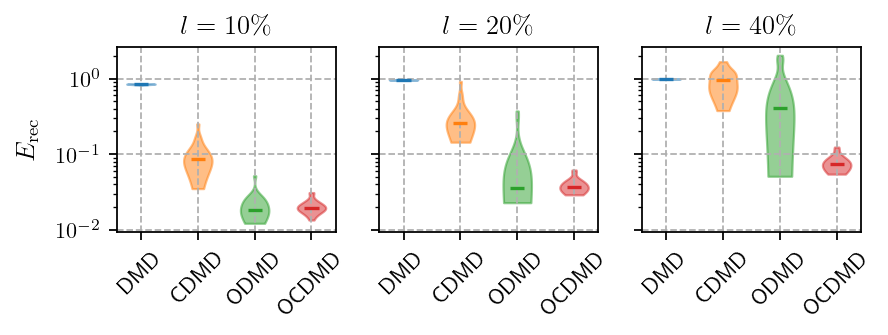

In [21]:
keys = (
    "DMD_l{}",
    "CDMD_l{}",
    "ODMD_l{}",
    "OCDMD_l{}"
)
labels = ("DMD", "CDMD", "ODMD", "OCDMD")
fig, axarr = plt.subplots(1, 3, figsize=(6, 1.5), sharex=True, sharey=True)

x_pos = list(range(1, len(labels)+1))
for i, l in enumerate(noise_levels):
    for j, key in enumerate(keys):
        pred_err = pt.tensor(results_comparative[key.format(l) + "_pred_err"])
        parts = axarr[i].violinplot(pred_err, [x_pos[j]], showmeans=False, showmedians=True, showextrema=False, widths=0.5)
        for pc in parts["bodies"]:
            pc.set_facecolor(f"C{j}")
            pc.set_edgecolor(f"C{j}")
            pc.set_alpha(0.5)
    axarr[i].set_yscale("log")
    axarr[i].set_xticks(x_pos)
    axarr[i].set_xticklabels(labels, rotation=45)
    axarr[i].grid(ls="--")
    axarr[i].set_title(rf"$l={l:2d}\%$")
fig.supylabel(r"$E_\mathrm{rec}$")
plt.savefig(join(output, "benchmark_models.png"), dpi=640, bbox_inches="tight")